In [45]:
import geopandas as gpd
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

import sys 
sys.path.insert(0, "../src")
from BrusselsMap import BrusselsMap
from GeoJsonHandler import GeoJsonHandler
from OSMGeoJsonHandler import OSMGeoJsonHandler

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 500)

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
r_path = r"../data/osm/overpass-turbo/sustenance.geojson"
path = os.path.join(os.getcwd(), r_path)

sus = OSMGeoJsonHandler(r_path, feature_type='sustenance')
sus.gdf["AREA"] = sus.gdf["AREA"]*1e6


3071


In [27]:
sus.gdf['AMENITY'].value_counts()

restaurant    1682
fast_food      589
pub            407
cafe           401
bar            366
ice_cream       30
Name: AMENITY, dtype: int64

In [28]:
len(sus.gdf)

3475

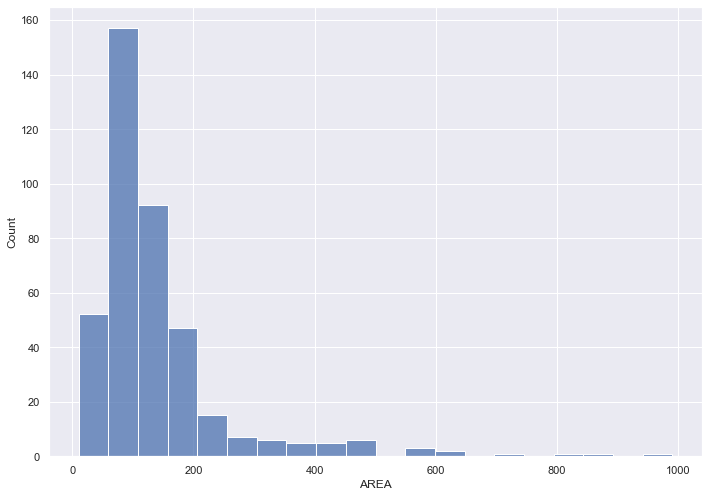

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()

data = sus.gdf[(sus.gdf["AREA"] < 1000) & (sus.gdf["AREA"] > 0)]

plot = sns.histplot(data.sort_values(by="AREA", ascending=False)["AREA"], bins=20)
# Save fig
# r_path = r"../data/osm/overpass-turbo/img/shops-raw.png"
# fig = plot.get_figure()
# fig.savefig(r_path) 

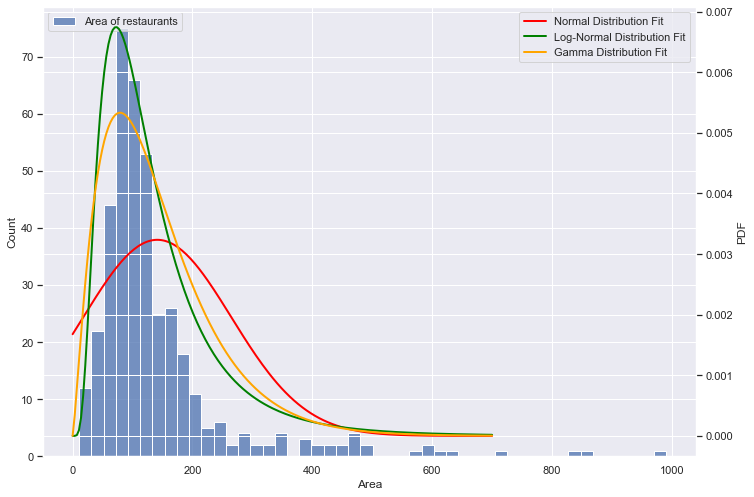

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()

data = sus.gdf[(sus.gdf["AREA"] < 1000) & (sus.gdf["AREA"] > 0)]["AREA"].to_numpy().reshape(-1)

fig, ax = plt.subplots()
plot = sns.histplot(data, label='Area of restaurants')

ax2 = plt.twinx()

#Fit & Plot Gaussian Distribution
mu, std = norm.fit(data)
x=np.linspace(0, 700, 200)
p = norm.pdf(x, mu, std)
sns.lineplot(x=x, y=p, ax=ax2, linewidth=2, color='red', label="Normal Distribution Fit")

# Fit a log Normal Distribution
param= stats.lognorm.fit(data, floc=0)
x=np.linspace(0, 700, 200)
log_p = stats.lognorm.pdf(x, param[0], loc=param[1], scale=param[2])
sns.lineplot(x=x, y=log_p, ax=ax2, linewidth=2, color='green', label="Log-Normal Distribution Fit")

# Fit a Gamma Distribution
fit_alpha, fit_loc, fit_beta= stats.gamma.fit(data, floc=0)
gamma_p = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
sns.lineplot(x=x, y=gamma_p, ax=ax2, linewidth=2, color='orange', label="Gamma Distribution Fit")


#Legends and Labels
ax.legend(loc="upper left")
ax2.legend()
ax.set(xlabel="Area", ylabel = "Count")
ax2.set(ylabel = "PDF")


# Save fig
r_path = r"../data/osm/overpass-turbo/img/restaurants-TypeI-Gaussian.png"
fig = plot.get_figure()
fig.savefig(r_path) 

In [53]:
param

(0.6574403045293078, 0.0, 111.6220388765379)

In [54]:
sus.gdf["AREA"] = sus.gdf["AREA"].apply(
    lambda x: stats.lognorm.rvs(
        param[0], param[1], param[2]
    )
    if x == 0
    else x
)

## Assign neighborhoods

In [55]:
#Load geodata
r_path = r"../data/final_data/sector.json"
path = os.path.join(os.getcwd(), r_path)
sectors = GeoJsonHandler(path, "NAME_FRE")

In [56]:
sus.assign_ngh(sectors)

  0%|                                                                                                                                          | 0/3475 [00:00<?, ?it/s]C:\Users\vic_t\Anaconda3\envs\mfe_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3475/3475 [05:36<00:00, 10.34it/s]


In [57]:
sus.gdf = sus.gdf[['ID', 'TYPE', 'NAME', 'AMENITY', 'geometry', 'AREA', 'LAT', 'LON', 'NAME_FRE']]
sus.gdf.head()

,ID,TYPE,NAME,AMENITY,geometry,AREA,LAT,LON,NAME_FRE
0,13855287,way,Quick,fast_food,"POLYGON ((4.35709 50.85377, 4.35737 50.85367, ...",595.654737,50.853766,4.357366,MARTYRS
1,23216362,way,Cercle Royal Gaulois Artistique et Littéraire,restaurant,"POLYGON ((4.36568 50.84519, 4.36566 50.84516, ...",2420.316969,50.845320,4.365513,QUARTIER ROYAL
2,30078475,way,Quick,fast_food,"POLYGON ((4.46110 50.84902, 4.46114 50.84896, ...",578.000417,50.848991,4.461352,KAPELLEVELD
3,31767978,way,Burger King,fast_food,"POLYGON ((4.42454 50.81513, 4.42468 50.81504, ...",828.385906,50.815048,4.424793,AUDERGHEM CENTRE
4,31767987,way,Pizza Hut,restaurant,"POLYGON ((4.42360 50.81509, 4.42363 50.81505, ...",451.377164,50.815173,4.423727,AUDERGHEM CENTRE


In [14]:
## Save results
r_path = r"../data/final_data/osm/sustenance.csv"
path = os.path.join(os.getcwd(), r_path)

sus.gdf.to_csv(path, sep=',', encoding='utf-8-sig', index=False, chunksize=10000)